In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import statistics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers.core import Dense, Activation, Dropout
import time  # helper libraries

from dataset_window import Dataset


def convertCash(cash):
	cash = cash.replace('.', '')
	cash = cash.replace(',', '.')
	return float(cash)

def clearNanMM(moving_average, price):
        moving_average[0] = price[0]
        moving_average[1] = (price[0] + price[1])/2
        moving_average[2] = (price[0] + price[1] + price[2])/3
        return moving_average;


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], [] 
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])

	return np.array(dataX), np.array(dataY)

#Carregando os dados
data = pd.read_csv("onion_price2.csv", parse_dates=['Mês'])
data.set_index('Mês', inplace=True)
index = data.index.values
# print(index)
data['Preço'] = data['Preço'].apply(convertCash)
data['PREÇO_DOLAR'] = data['PREÇO_DOLAR'].apply(convertCash)

import talib as ta

data['MEDIA_MOVEL'] = ta.EMA(data['Preço'], timeperiod=4)
data['MEDIA_MOVEL'] = clearNanMM(data['MEDIA_MOVEL'], data['Preço'])

# data['MEDIA_MOVEL_DOLAR'] = ta.EMA(data['PREÇO_DOLAR'], timeperiod=4)
# data['MEDIA_MOVEL_DOLAR'] = clearNanMM(data['MEDIA_MOVEL_DOLAR'], data['PREÇO_DOLAR'])

print(data)

            Preço  PREÇO_DOLAR  MEDIA_MOVEL
Mês                                        
2016-01-01  53.20       3.9988    53.200000
2016-02-01  56.50       4.0171    54.850000
2016-03-01  54.00       3.5935    54.566667
2016-04-01  46.40       3.4358    52.525000
2016-05-01  50.00       3.6111    51.515000
2016-06-01  25.80       3.2134    41.229000
2016-07-01  12.75       3.2486    29.837400
2016-08-01  13.00       3.2273    23.102440
2016-09-01  13.25       3.2603    19.161464
2016-10-01   6.13       3.1893    13.948878
2016-11-01  13.00       3.3842    13.569327
2016-12-01  17.50       3.2547    15.141596
2017-01-01  20.50       3.1509    17.284958
2017-02-01  28.00       3.1091    21.570975
2017-03-01  24.00       3.1233    22.542585
2017-04-01  23.00       3.1766    22.725551
2017-05-01  19.48       3.2266    21.427331
2017-06-01  17.82       3.3072    19.984398
2017-07-01  30.52       3.1264    24.198639
2017-08-01  25.13       3.1479    24.571183
2017-09-01  24.33       3.1619  

In [2]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_dollar = MinMaxScaler(feature_range=(0,1))
scaler_media_movel = MinMaxScaler(feature_range=(0,1))
data['Preço'] = scaler_price.fit_transform(data['Preço'].to_numpy().reshape(-1, 1))
data['PREÇO_DOLAR'] = scaler_dollar.fit_transform(data['PREÇO_DOLAR'].to_numpy().reshape(-1, 1))
data['MEDIA_MOVEL'] = scaler_dollar.fit_transform(data['MEDIA_MOVEL'].to_numpy().reshape(-1, 1))
# data['MEDIA_MOVEL_DOLAR'] = scaler_dollar.fit_transform(data['MEDIA_MOVEL_DOLAR'].to_numpy().reshape(-1, 1))

In [3]:
x,y = create_dataset(data.values, 4)

In [4]:
train_x, test_x = x[0:32, :], x[32:, :]

train_y, test_y = y[0:32], y[32:]

print(test_y.shape)

(12,)


In [5]:
model = Sequential()
model.add(LSTM(25, input_shape=(4, 3)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, verbose=1)

trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1080
Epoch 2/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.1022
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0989
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0917
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0942
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0847
Epoch 7/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0807
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0761
Epoch 9/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0727
Epoch 10/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0710
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0653
Epoch 12/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0640
Epoch 13/1000
1/1 [==============================]

In [6]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [7]:
trainPredict = scaler_price.inverse_transform(trainPredict)
train_y = scaler_price.inverse_transform([train_y])

testPredict = scaler_price.inverse_transform(testPredict)
test_y = scaler_price.inverse_transform([test_y])

print(testPredict)

[[79.75199 ]
 [86.199684]
 [58.83344 ]
 [32.38007 ]
 [31.48211 ]
 [29.408043]
 [53.227295]
 [82.930405]
 [66.21434 ]
 [31.880663]
 [14.362277]
 [10.961395]]


In [8]:
#calculate mean absolute error
mape_train = mean_absolute_percentage_error(train_y[0], trainPredict)
print('Train Score: %.2f MAPE' % (mape_train))
mape_test = mean_absolute_percentage_error(test_y[0], testPredict)
print('Test Score: %.2f MAPE' % (mape_test))
print('\n -----------------------------------------\n')
#calculate mean absolute error
mae_train = mean_absolute_error(train_y[0], trainPredict)
print('Train Score: %.2f MAE' % (mae_train))
mae_test = mean_absolute_error(test_y[0], testPredict)
print('Test Score: %.2f MAE' %(mae_test))
print('\n -----------------------------------------\n')
# calculate root mean squared error
rmse_train = math.sqrt(mean_squared_error(train_y[0], trainPredict))
print('Train Score: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(test_y[0], testPredict))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 0.22 MAPE
Test Score: 0.33 MAPE

 -----------------------------------------

Train Score: 5.02 MAE
Test Score: 14.59 MAE

 -----------------------------------------

Train Score: 6.34 RMSE
Test Score: 18.53 RMSE


In [9]:
import talib as ta

mma = ta.EMA(testPredict.reshape(-1).astype('double'), timeperiod = 4)

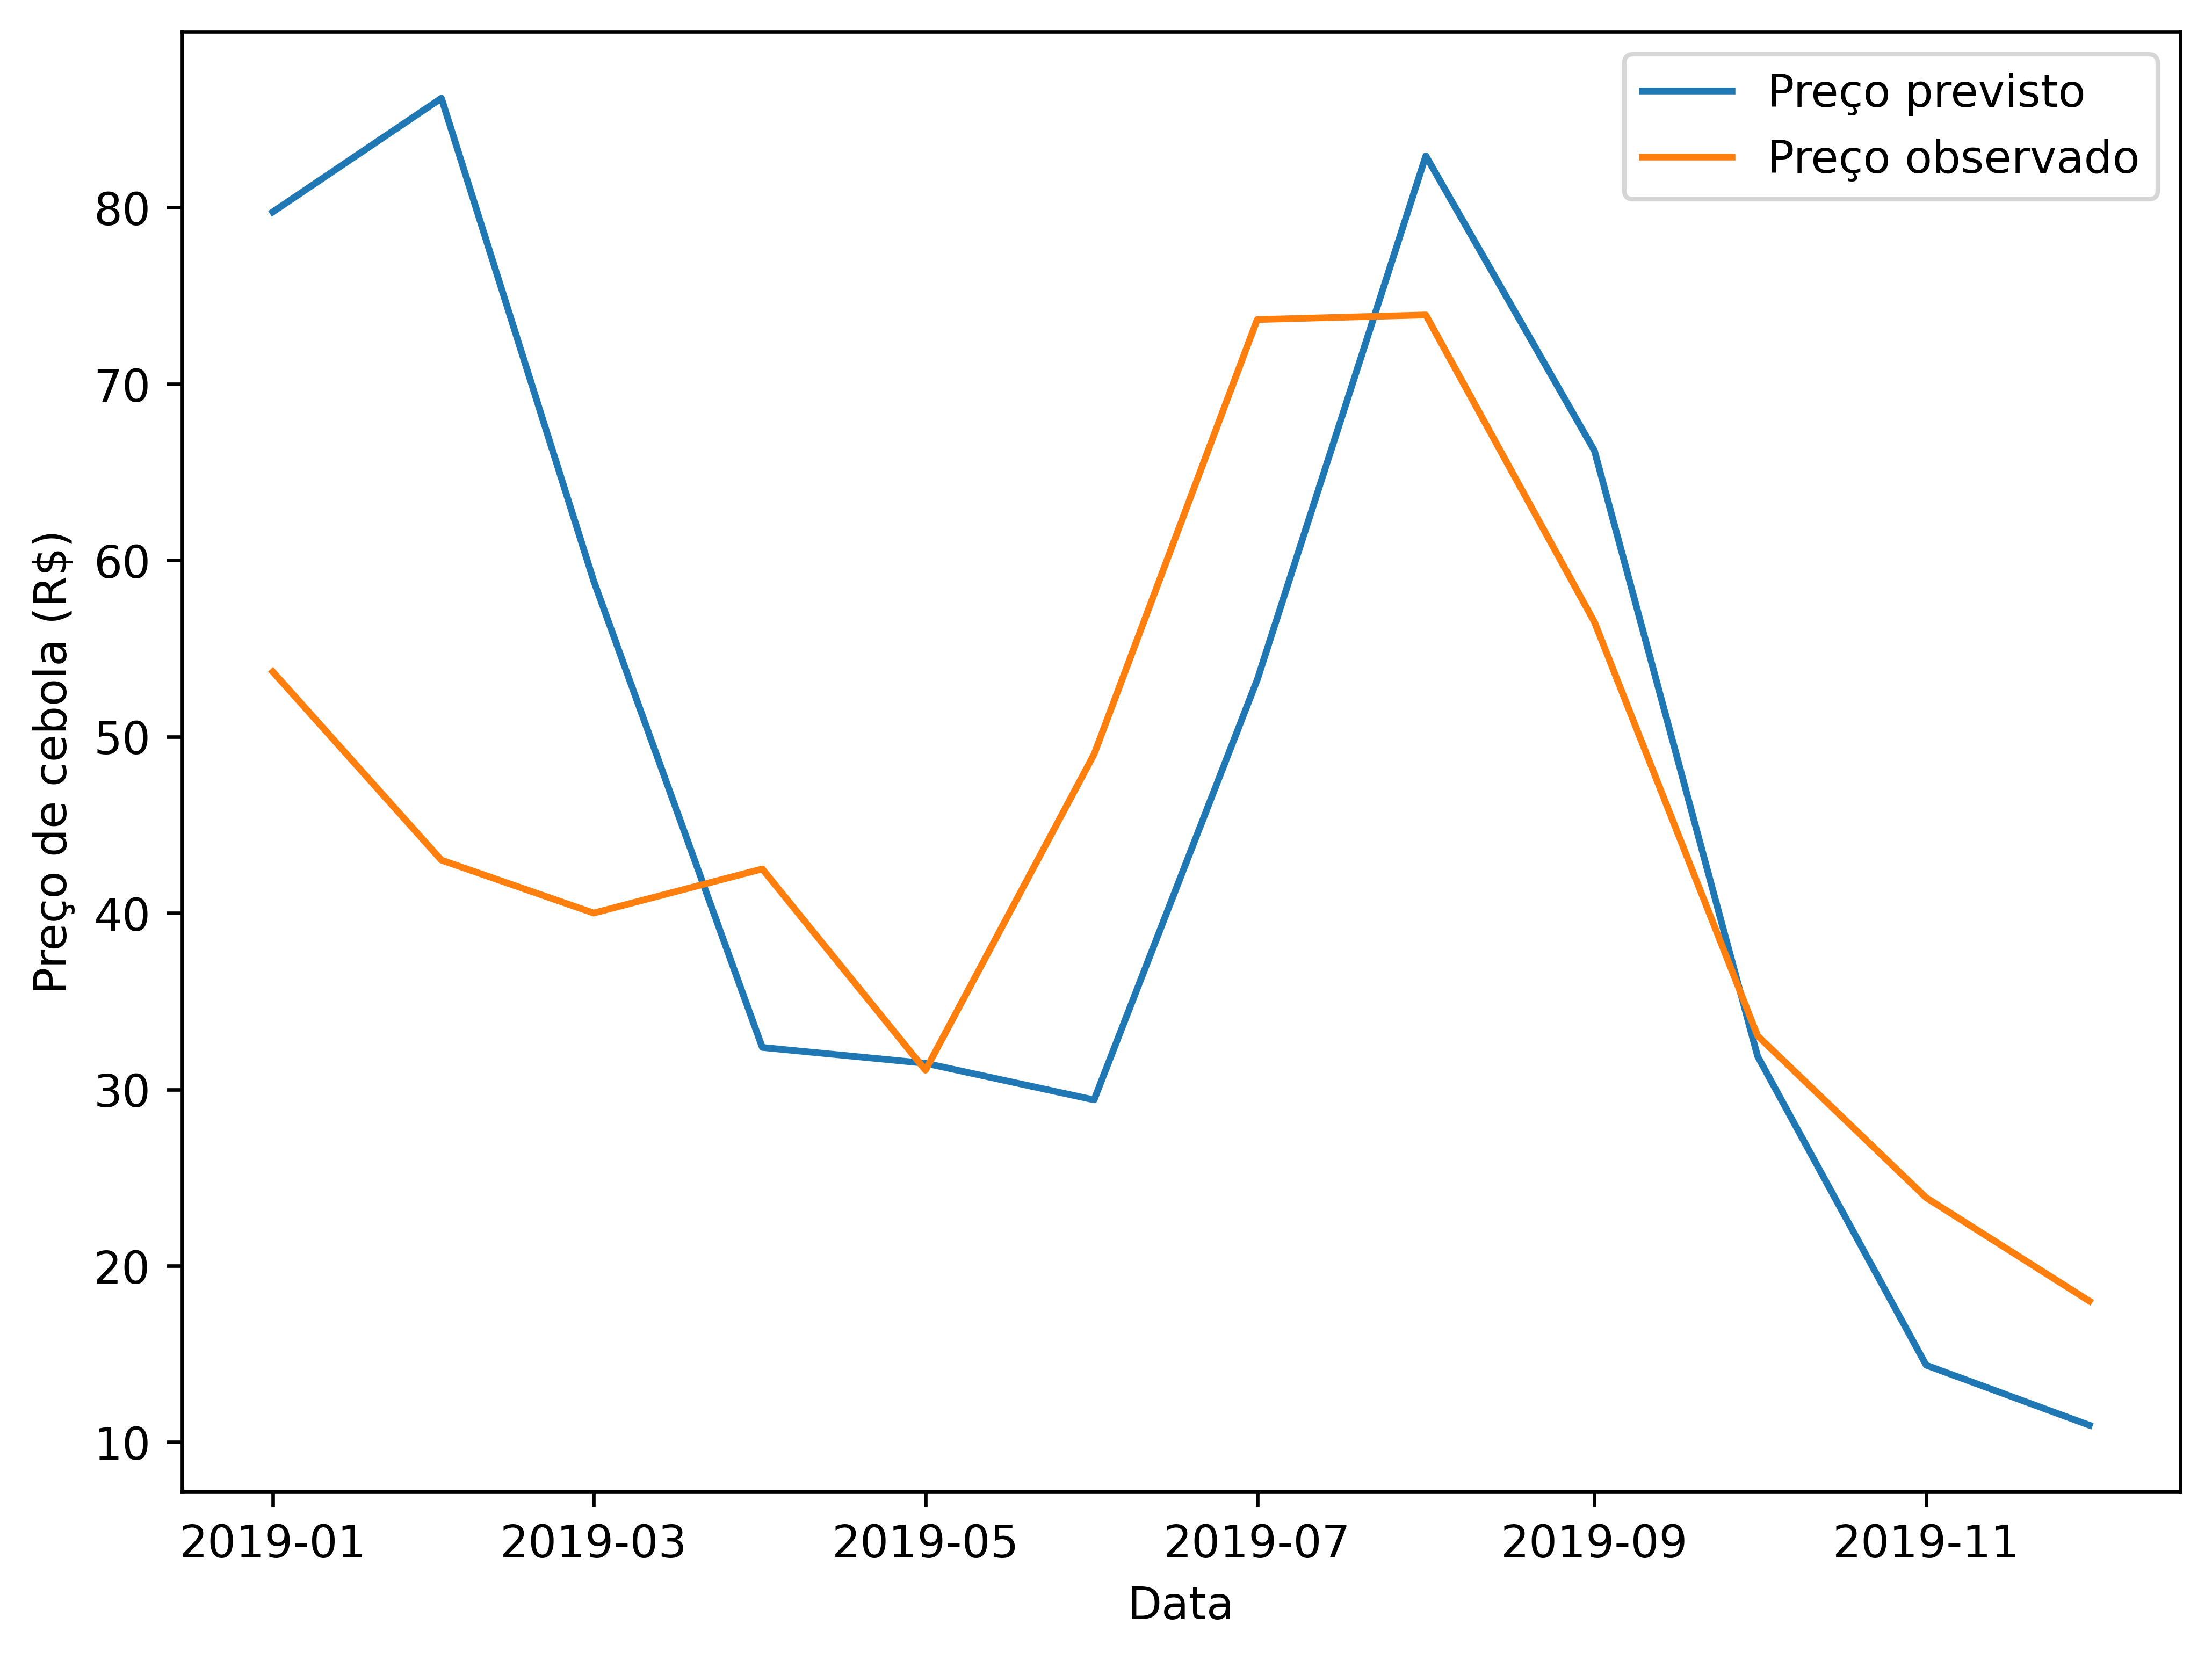

In [10]:
fig = plt.figure(figsize=(8, 6), dpi=600)
plt.plot(index[36:], testPredict, label='Preço previsto')
plt.plot(index[36:], test_y.reshape(-1, 1), label='Preço observado')
# plt.plot(index[36:], mma, label="Média móvel")
plt.ylabel('Preço de cebola (R$)')
plt.xlabel('Data')
plt.legend()
plt.show()
fig.savefig('moving_average.png')